In [45]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import yaml
import json
import sys


plt.style.use('seaborn-v0_8-paper')

# Util

In [46]:
def get_parameters(path: str):
    parameters_path = os.path.join(path, 'parameters.yml')

    with open(parameters_path) as f:
        parameters = yaml.safe_load(f)

    return parameters

In [47]:
def plot_value(path: str, info: dict, figsize=(8,8), post_process_fn = lambda a: a):
    if not os.path.exists(path):
        raise ValueError('No loss file exists')

    df = pd.read_csv(path)

    fig, ax = plt.subplots(figsize=figsize)

    if 'work_center_id' in df.columns:
        work_centers = df['work_center_id'].unique()
        machines = df['machine_id'].unique()

        for work_center_id in work_centers:
            for machine_id in machines:
                filtered = df[(df['work_center_id'] == work_center_id) & (df['machine_id'] == machine_id)]
                filtered.set_index(info['index'], inplace=True)

                if len(machines) == 1:
                    label = f'M_idx: {work_center_id}'
                else:
                    label = f'W_idx: {work_center_id}, M_idx: {machine_id}'

                ax.plot(post_process_fn(filtered[info['column']]), label=label)
    else:
        df.set_index(info['index'], inplace=True)

        ax.plot(post_process_fn(df[info['column']]))

    ax.grid(True)
    ax.set_title(info['title'])
    ax.set_xlabel(info['xlabel'])
    ax.set_ylabel(info['ylabel'])

    ax.legend()

    return fig, df

In [48]:
def plot_reward_distribution_per_action(data: pd.DataFrame, figsize=(8, 8)):
    data = data[data['reward'] != 0]

    fig, ax = plt.subplots(figsize=figsize)

    # Create violins for each action
    for i, action in enumerate(data["action"].unique()):
        action_data = data[data["action"] == action]["reward"]
        violin_parts = ax.violinplot(
            action_data,
            positions=[i],
            showmeans=True,
            showextrema=True,
            quantiles=[0.25, 0.5, 0.75],
        )

        violin_parts['bodies'][0].set_linewidth(2)

    # Set labels and title
    ax.set_xlabel("Action")
    ax.set_ylabel("Reward")
    ax.set_title("Violin Plot of Rewards by Action")

    # Add grid and adjust layout
    ax.grid(True)
    plt.tight_layout()

    return fig


In [106]:
def plot_reward_per_run(data, info, format_group):
    metric = info['metric']
    reward = info['reward']
    group = info['group']

    fig, ax = plt.subplots(figsize=(12, 6))

    for run in np.sort(data[group].unique()):
        filtered = data[data[group] == run]

        ax.plot(filtered[metric], filtered[reward], marker=info['marker'], ls='', label=format_group(run))

    ax.grid(True)
    ax.legend()

    ax.set_xlabel(info['xlabel'])
    ax.set_ylabel(info['ylabel'])
    ax.set_title(info['title'])

    plt.tight_layout()

    return fig

def plot_reward_per_model_across_runs(data, info):
    metric = info['metric']
    reward = info['reward']
    group = info['group']
    candidate_column = info['candidate_column']
    candidate = info['candidate']

    fig, ax = plt.subplots(figsize=(12, 6))

    for run in np.sort(data[group].unique()):
        filtered = data[data[group] == run]

        ax.plot(filtered[metric], filtered[reward], marker=info['marker'], ls='', c='gray')

    filtered = data[data[candidate_column] == candidate]

    ax.plot(filtered[metric], filtered[reward], marker=info['marker'], ms=10, ls='', c='r')

    ax.grid(True)

    ax.set_xlabel(info['xlabel'])
    ax.set_ylabel(info['ylabel'])
    ax.set_title(info['title'] + candidate)

    plt.tight_layout()

    return fig

In [89]:
def filter_models(dataset, predicate):
    result = []

    for directory in os.listdir(dataset):
        directory_path = os.path.join(dataset, directory)

        if not os.path.isdir(directory_path):
            continue

        parameters = get_parameters(directory_path)

        if predicate(parameters):
            result += [directory]

    return result

# JSP

In [90]:
dataset = '../diploma_thesis/tmp/jsp_multi'

## Training

In [131]:
candidate_path = os.path.join(dataset, 'model_112')

In [132]:
agent_path = os.path.join(candidate_path, 'agent')

### Parameters

In [133]:
parameters = get_parameters(candidate_path)

print(json.dumps(parameters, indent=4))

{
    "log_stdout": false,
    "machine_agent": {
        "kind": "mod",
        "parameters": {
            "base_path": "configuration/mods/machine_agent/model.yml",
            "mods": [
                "rl/trainer/ddqn.yml",
                "rl/agent/single.yml",
                "memory/plain.yml",
                "loss/mse.yml",
                "optimizer/adam.yml",
                "encoding/mr.yml",
                "model/rules/marl.yml",
                "model/model/marl_mr.yml"
            ]
        }
    },
    "name": "model_112",
    "output_dir": "tmp/jsp_multi",
    "run": {
        "kind": "mod",
        "parameters": {
            "base_path": "configuration/mods/run/jsp/run.yml",
            "mods": [
                "multi.yml"
            ]
        }
    },
    "simulator": {
        "kind": "td"
    },
    "tape": {
        "machine_reward": {
            "kind": "global_decomposed_tardiness",
            "parameters": {
                "span": 256
            }
    

### Loss

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


,Unnamed: 0,value
optimizer_step,,
1,0,0.008695
2,1,0.006870
3,2,0.008491
4,3,0.008280
5,4,0.003770
...,...,...
57913,57912,0.032348
57914,57913,0.029042
57915,57914,0.031667


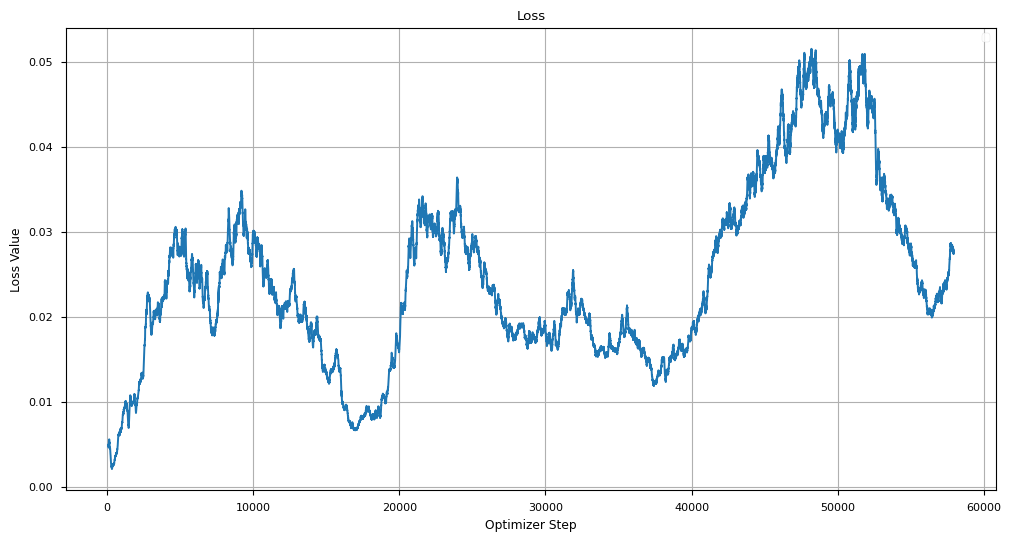

In [134]:
def smooth(x):
    return x.rolling(window=100).mean()

machine_loss = os.path.join(agent_path, 'machine_loss.csv')

fig, loss = plot_value(
    machine_loss,
    info=dict(
        column='value',
        title='Loss',
        xlabel='Optimizer Step',
        ylabel='Loss Value',
        index='optimizer_step'
    ),
    figsize=(12, 6),
    post_process_fn=smooth)

loss

### Reward

,shop_floor_id,action,machine_id,work_center_id,moment,reward
0,2,0,0,4,201057.953125,0.000000
1,2,0,0,1,201102.937500,0.000000
2,2,0,0,8,201123.937500,0.000000
3,2,0,0,9,201124.937500,0.000000
4,2,0,0,6,201156.937500,0.000000
...,...,...,...,...,...,...
32822,2,3,0,0,299622.656250,-1.000000
32823,2,1,0,9,299731.718750,-0.172703
32824,2,0,0,8,299808.656250,-0.082054
32825,2,0,0,6,299822.656250,-0.010714


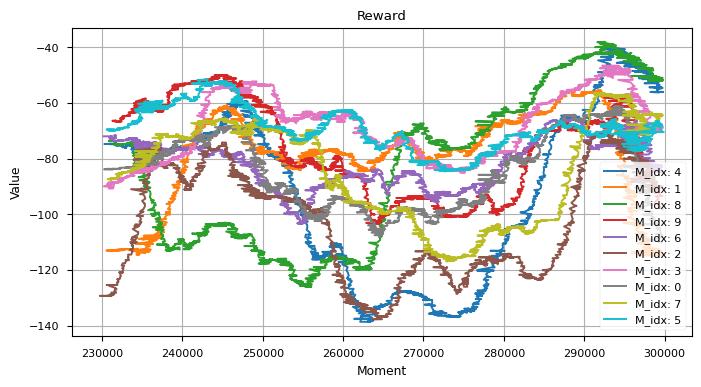

In [136]:
def sum(x):
    return x.rolling(window=1000).sum()

run = '_3'

machine_reward = os.path.join(candidate_path, 'run', run, 'machine_reward.csv')

fig, reward = plot_value(
    machine_reward,
    info=dict(
        column='reward',
        title='Reward',
        xlabel='Moment',
        ylabel='Value',
        index='moment'
    ),
    figsize=(8, 4),
    post_process_fn=sum)

reward

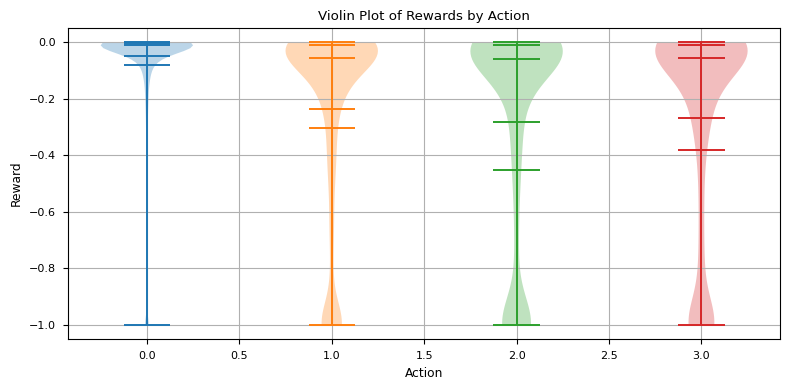

In [137]:
plot_reward_distribution_per_action(reward, figsize=(8,4));

#### Decisions per machine

In [127]:
plt.bar(result['action'])

TypeError: list indices must be integers or slices, not str

## Tournament

#### Tournament Result

In [97]:
tournament_path = '../diploma_thesis/tmp/jsp_tournament'

In [98]:
report_path = os.path.join(tournament_path, 'report.txt')

with open(report_path) as f:
    result = f.readlines()

print(''.join(result))

+----------------------------------------+----------------------+-----------------------+----------------------+
|               candidate                |   makespan_reward    |   tardiness_reward    |      total_sum       |
+----------------------------------------+----------------------+-----------------------+----------------------+
|             multi_model_45             | 0.06446300097741187  |  0.04702721089212103  |  0.1114902118695329  |
|   CRSPTSchedulingRule_CTRoutingRule    | 0.058594294590875506 |  0.05234542388381625  | 0.11093971847469175  |
|  SPMWKSPTSchedulingRule_CTRoutingRule  | 0.058594294590875506 |  0.05234542388381625  | 0.11093971847469175  |
|            multi_model_112             | 0.056200119433924556 | 0.054353318117185814  | 0.11055343755111037  |
|             multi_model_76             |  0.0607807053020224  |  0.04962126659197527  | 0.11040197189399767  |
|       multi-concurrent_model_25        | 0.05568996327929199  | 0.054375887675539185  | 0.1100

In [99]:
result_path = os.path.join(tournament_path, 'result.csv')
results = pd.read_csv(result_path)

#### Tournament Reward Distribution per Simulation

In [100]:
results

,Unnamed: 0,candidate,run,makespan,tardiness,makespan_reward,tardiness_reward
0,0,ATCSchedulingRule_CTRoutingRule,_1,6975.4410,112.191605,0.004160,0.003431
1,1,ATCSchedulingRule_CTRoutingRule,_2,7590.0376,75.801910,0.000764,0.004269
2,2,ATCSchedulingRule_CTRoutingRule,_3,5863.6836,324.494690,0.005032,0.003275
3,3,ATCSchedulingRule_CTRoutingRule,_4,7198.0684,188.008789,0.003476,0.002656
4,4,ATCSchedulingRule_CTRoutingRule,_5,6600.6016,145.458664,0.002912,0.004150
...,...,...,...,...,...,...,...
4765,4765,multi_model_102,_11,6620.9220,287.123138,0.004242,0.001920
4766,4766,multi_model_102,_12,6521.8670,218.498245,0.003052,0.003424
4767,4767,multi_model_102,_13,7829.9453,67.654686,0.001961,0.004311
4768,4768,multi_model_102,_14,7276.1562,114.985977,0.001518,0.004106


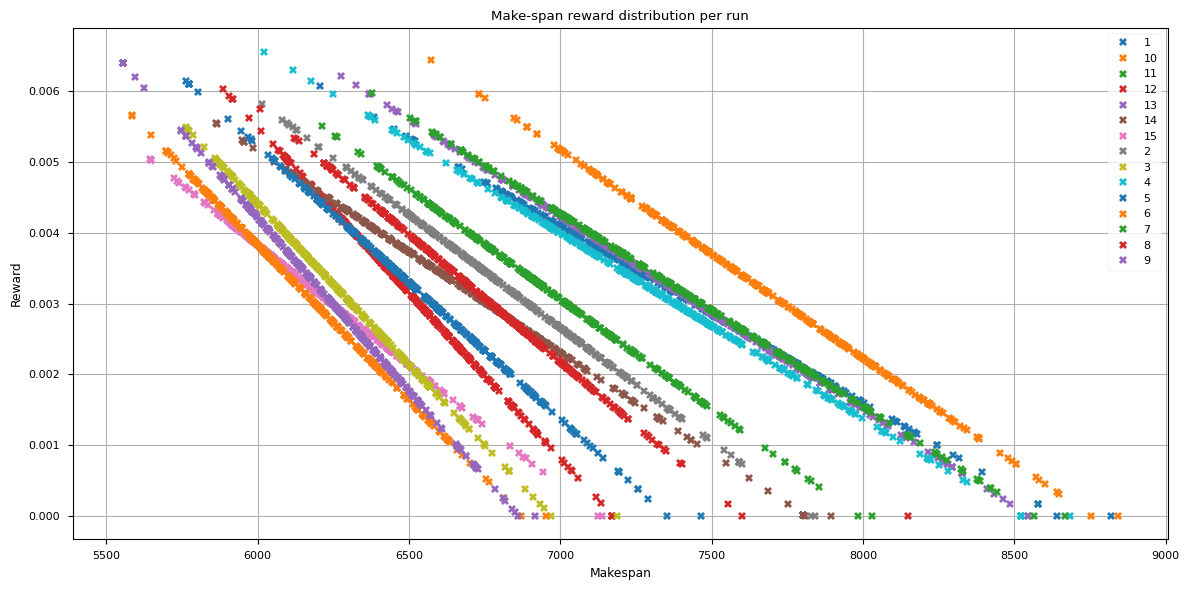

In [101]:
plot_reward_per_run(
    results,
    info=dict(
        title='Make-span reward distribution per run',
        xlabel='Makespan',
        ylabel='Reward',
        marker='X',
        metric='makespan',
        reward='makespan_reward',
        group='run'
    ),
    format_group=lambda x: x.strip('_')
);

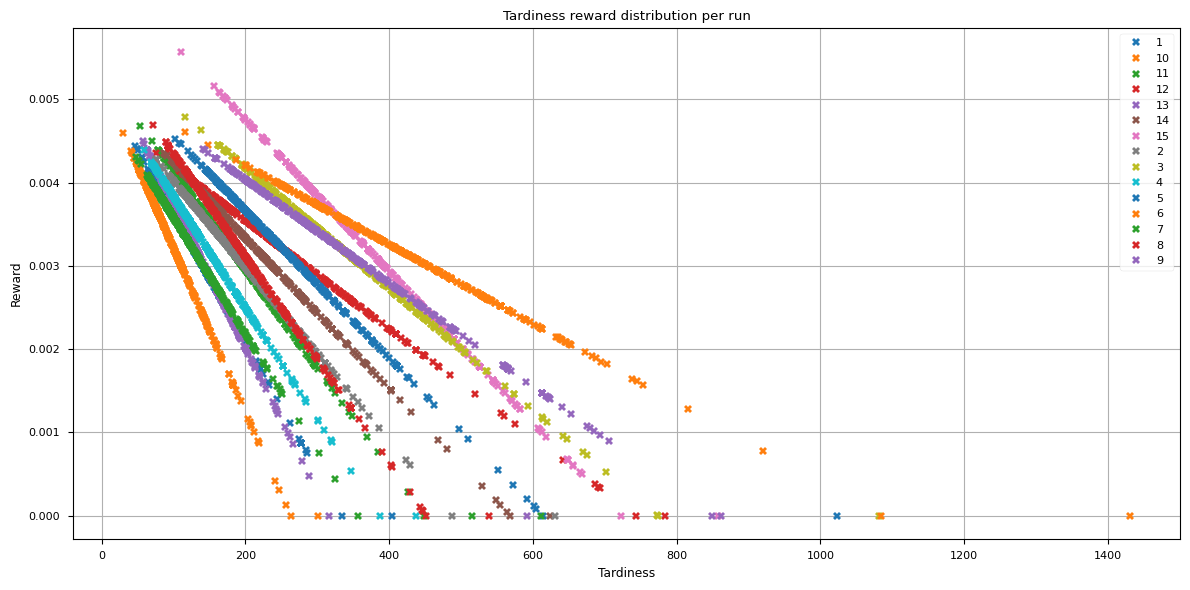

In [102]:
plot_reward_per_run(
    results,
    info=dict(
        title='Tardiness reward distribution per run',
        xlabel='Tardiness',
        ylabel='Reward',
        marker='X',
        metric='tardiness',
        reward='tardiness_reward',
        group='run'
    ),
    format_group=lambda x: x.strip('_')
);

#### Reward Distribution per model

In [128]:
model = 'multi_model_112'

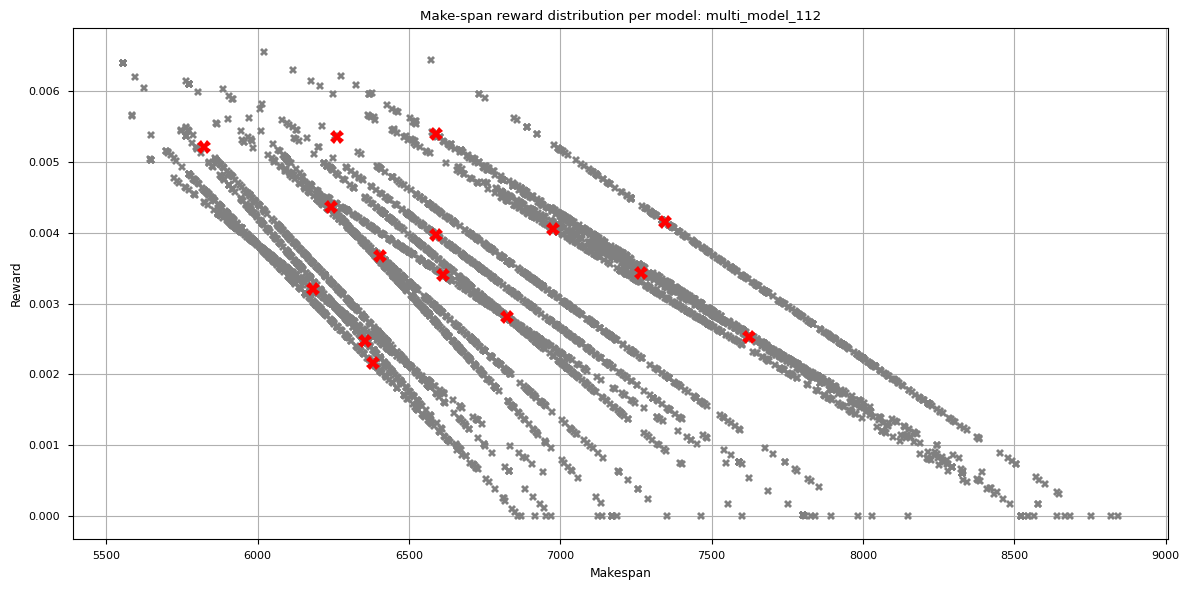

In [129]:
plot_reward_per_model_across_runs(
    results,
    info=dict(
        title='Make-span reward distribution per model: ',
        xlabel='Makespan',
        ylabel='Reward',
        marker='X',
        metric='makespan',
        reward='makespan_reward',
        candidate_column='candidate',
        candidate=model,
        group='run'
    )
);

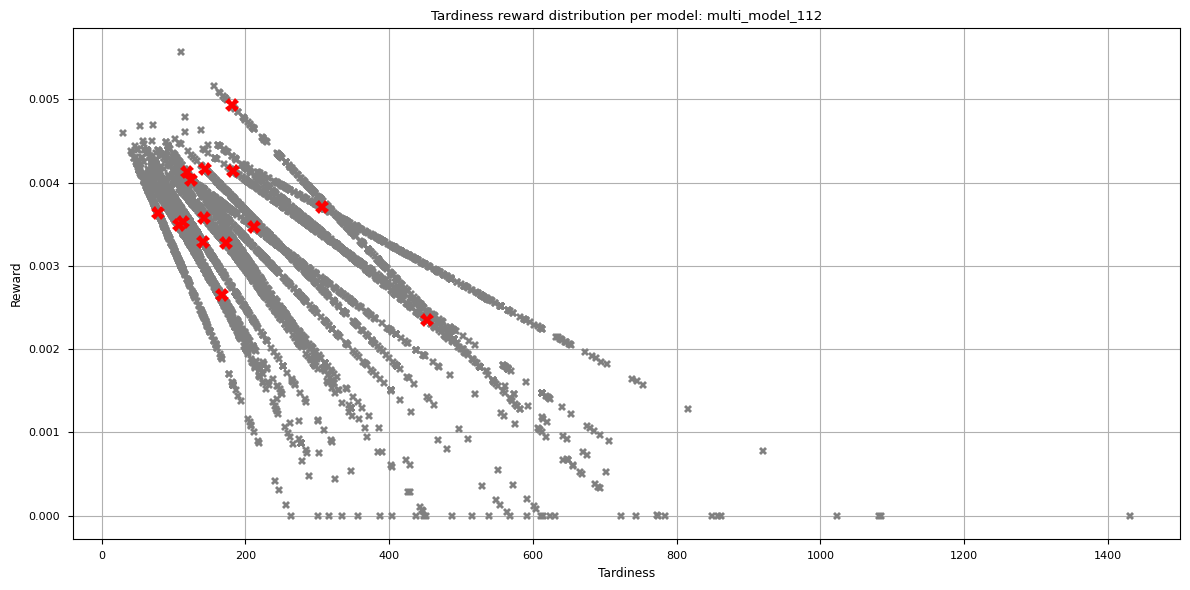

In [130]:
plot_reward_per_model_across_runs(
    results,
    info=dict(
        title='Tardiness reward distribution per model: ',
        xlabel='Tardiness',
        ylabel='Reward',
        marker='X',
        metric='tardiness',
        reward='tardiness_reward',
        candidate_column='candidate',
        candidate=model,
        group='run'
    )
);

#### Analyze results

In [108]:
reward_columns = [column for column in results.columns if 'reward' in column ]

results_per_candidate = results.copy()

results_per_candidate = results_per_candidate[['candidate', *reward_columns]].groupby(['candidate']).sum()
results_per_candidate['reward'] = 0

for column in reward_columns:
    results_per_candidate['reward'] += results_per_candidate[column]

results_per_candidate = results_per_candidate.sort_values(by=['reward'], ascending=False).reset_index()

results_per_candidate

,candidate,makespan_reward,tardiness_reward,reward
0,multi_model_45,0.064463,0.047027,0.111490
1,CRSPTSchedulingRule_CTRoutingRule,0.058594,0.052345,0.110940
2,SPMWKSPTSchedulingRule_CTRoutingRule,0.058594,0.052345,0.110940
3,multi_model_112,0.056200,0.054353,0.110553
4,multi_model_76,0.060781,0.049621,0.110402
...,...,...,...,...
313,multi_model_78,0.045074,0.028026,0.073100
314,multi_model_1,0.039114,0.033921,0.073035
315,multi-concurrent_model_24,0.041799,0.017039,0.058838
316,multi_model_139,0.032290,0.023119,0.055409


In [109]:
def filter_by_mod(parameters, predicate):
    mods = parameters['machine_agent']['parameters']['mods']

    for mod in mods:
        if predicate(mod):
            return True

    return False

models = filter_models(dataset, lambda parameters: filter_by_mod(parameters, lambda mod: 'priori' in mod))

In [110]:
len(models)

72

In [111]:
candidates = results_per_candidate[results_per_candidate['candidate'].isin(models)]

candidates

,candidate,makespan_reward,tardiness_reward,reward


## Simulation Analysis